# Libraries

In [1]:
# === Install required packages ===
!pip install pandas openpyxl shap bokeh

# === Data manipulation and visualization ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# === Preprocessing and machine learning models ===
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    classification_report, confusion_matrix, roc_auc_score
)

# === Interactive visualization with Bokeh ===
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import (
    ColumnDataSource, LinearColorMapper, ColorBar,
    BasicTicker, PrintfTickFormatter, LabelSet
)
from bokeh.transform import transform
from bokeh.palettes import RdBu as palette, Blues7

# Enable Bokeh display in notebook
output_notebook()


#Exploratory Data Analysis

## Pre exposure data

In [ ]:
# Load the pre-exposure dataset from the specified path
df = '/content/pre_exposure_data.xlsx'
df = pd.read_excel(df)
# Display the first few rows of the dataset
print(df.head())

   Edad  Sexo  Nacionalidad  (P1)  A1  A2  A3  A4  A5  A6  ...  RS  TV.2  \
0    18     2             1     5   7   1   1   5   1   7  ...   1     6   
1    19     2             1     6   6   6   2   5   5   5  ...   5     5   
2    22     2             3     4   4   6   2   6   4   5  ...   7     4   
3    19     1             1     5   4   5   2   3   4   5  ...   5     4   
4    20     1             1     4   1   4   2   4   6   4  ...   5     2   

   PD.1  RS.1  (P10)  I.1  C.1  D      (P12)  Condition  
0     1     3      6    0    0  0  Era menor   Positivo  
1     4     4      5    0    0  1  Ciudadano   Positivo  
2     4     7      5    0    0  0        NaN   Positivo  
3     4     4      4    0    1  0        NaN   Positivo  
4     5     5      4    1    0  0    No votè   Positivo  

[5 rows x 46 columns]


In [ ]:
# Create a new column called 'Political Orientation' based on binary indicators:
# If 'I.1' (Izquierda / Left) is 1 → assign 1
# If 'C.1' (Centro / Center) is 1 → assign 2
# If 'D'   (Derecha / Right) is 1 → assign 3
# If none of the above → assign 0
df['Orientacion Politica'] = df.apply(
    lambda row: 1 if row['I.1'] == 1 else (
        2 if row['C.1'] == 1 else (
            3 if row['D'] == 1 else 0
        )
    ),
    axis=1
)

# Drop the original columns used to derive 'Political Orientation'
df = df.drop(columns=['I.1', 'C.1', 'D'])

# Display the first few values of the new column
print(df[['Orientacion Politica']].head())


   Orientacion Politica
0                     0
1                     3
2                     0
3                     2
4                     1


In [ ]:
# Drop irrelevant or redundant columns: P12 (question), 'Otro' (other), and 'Nacionalidad' (nationality)
df = df.drop(columns=['(P12)', 'Otro', 'Nacionalidad'])

# Remove rows with any missing values to ensure clean correlation analysis
data_cleaned = df.dropna()

# Encode the 'Condition' column as binary:
# 'Positivo' → 0, 'Negativo' → 1
# This allows inclusion in correlation analysis
data_cleaned['Condition'] = data_cleaned['Condition'].map({'Positivo': 0, 'Negativo': 1})

# Confirm encoding
print(data_cleaned['Condition'].value_counts())

# Compute correlation matrix
corr = data_cleaned.corr(method='spearman')

# Convert to long format for Bokeh
corr_matrix = corr.copy()
corr_matrix.index.name = 'y'
corr_matrix.columns.name = 'x'
corr_long = corr_matrix.stack().rename("value").reset_index()

# Color mapper
mapper = LinearColorMapper(palette=palette[11][::-1], low=-1, high=1)

# Create figure
p = figure(
    title="Correlation Matrix (Spearman)",
    x_range=list(corr.columns), y_range=list(reversed(corr.index)),
    x_axis_location="above", tools="hover", toolbar_location='right',
    tooltips=[('Var X', '@x'), ('Var Y', '@y'), ('ρ', '@value{0.2f}')]
)

p.rect(
    x="x", y="y", width=1, height=1,
    source=corr_long,
    line_color=None,
    fill_color=transform("value", mapper)
)

# Color bar
color_bar = ColorBar(
    color_mapper=mapper, major_label_text_font_size="10pt",
    ticker=BasicTicker(desired_num_ticks=10),
    formatter=PrintfTickFormatter(format="%.2f"),
    label_standoff=12, location=(0, 0)
)
p.add_layout(color_bar, 'right')

p.xaxis.major_label_orientation = 1.2
p.title.text_font_size = '16pt'
p.grid.grid_line_color = None

# Show plot
show(p)

Condition
1    69
0    61
Name: count, dtype: int64


In [ ]:
# Extract the correlation values for the 'Political Orientation' variable from the correlation matrix
orientacion_correlations = corr_matrix['Orientacion Politica']

# Convert the correlations to a DataFrame for easier handling
orientacion_correlations_df = orientacion_correlations.reset_index()
orientacion_correlations_df.columns = ['Variable', 'Correlation']

# Remove the self-correlation (correlation of the variable with itself)
orientacion_correlations_df = orientacion_correlations_df[
    orientacion_correlations_df['Variable'] != 'Orientacion Politica'
]

# Get the 10 variables with the highest positive correlation
top_10_orientacion_correlations = orientacion_correlations_df.nlargest(10, 'Correlation')

# Get the 10 variables with the most negative correlation
bottom_10_orientacion_correlations = orientacion_correlations_df.nsmallest(10, 'Correlation')

# Display the results
print("Top 10 variables most positively correlated with Political Orientation:")
print(top_10_orientacion_correlations)

print("\nTop 10 variables most negatively correlated with Political Orientation:")
print(bottom_10_orientacion_correlations)



Top 10 variables most positively correlated with Political Orientation:
     Variable  Correlation
35       TV.2     0.349010
36       PD.1     0.339637
20       (P5)     0.261203
9          A7     0.248090
14         E4     0.234340
33         PD     0.229390
32       TV.1     0.214705
39  Condition     0.212564
13         E3     0.212196
22         CA     0.200824

Top 10 variables most negatively correlated with Political Orientation:
   Variable  Correlation
19   (P4.2)    -0.268457
18   (P4.1)    -0.258771
2      (P1)    -0.218684
30       NR    -0.200655
26        R    -0.153227
10       A8    -0.133809
12       E2    -0.132894
0      Edad    -0.130678
6        A4    -0.122076
1      Sexo    -0.108045


In [ ]:
# Convert the correlation matrix to long format (pairwise correlations)
correlation_long = corr_matrix.stack().reset_index()
correlation_long.columns = ['Variable1', 'Variable2', 'Correlation']

# Remove duplicate pairs and self-correlations
# Keep only one instance per pair (e.g., keep A-B but not B-A)
correlation_long = correlation_long[correlation_long['Variable1'] < correlation_long['Variable2']]

# Get the 10 strongest positive correlations
top_10_correlations = correlation_long.nlargest(10, 'Correlation')

# Get the 10 strongest negative correlations
bottom_10_correlations = correlation_long.nsmallest(10, 'Correlation')

# Display the results
print("Top 10 strongest positive correlations:")
print(top_10_correlations)

print("\nTop 10 strongest negative correlations:")
print(bottom_10_correlations)


Top 10 strongest positive correlations:
     Variable1 Variable2  Correlation
1511      PD.1      TV.2     0.748261
464         E1        E3     0.742770
1431        RS      RS.1     0.704136
547         E3        E4     0.666925
465         E1        E4     0.657616
590         E4        E6     0.637314
338         A6        A8     0.633963
1385        PD      TV.1     0.631192
467         E1        E6     0.592291
549         E3        E6     0.583357

Top 10 strongest negative correlations:
    Variable1 Variable2  Correlation
96       (P1)        E4    -0.527332
93       (P1)        E1    -0.502606
91       (P1)        A7    -0.480314
95       (P1)        E3    -0.448172
752    (P4.1)        E4    -0.401394
747    (P4.1)        A7    -0.395383
98       (P1)        E6    -0.393980
751    (P4.1)        E3    -0.383327
87       (P1)        A3    -0.369685
754    (P4.1)        E6    -0.336557


In [ ]:
def visualizar_datos_bokeh(df, data_cleaned):
    output_notebook()

    # --- HEATMAP ---
    cross_tab = pd.crosstab(df['Sexo'], df['Orientacion Politica'])
    sexo_labels = {1: "Male", 2: "Female"}
    cross_tab.index = cross_tab.index.map(sexo_labels)
    orientacion_labels = {0: "None", 1: "Left", 2: "Center", 3: "Right"}
    cross_tab.columns = cross_tab.columns.map(orientacion_labels)
    data = cross_tab.values
    orientacion_labels = cross_tab.columns.astype(str).tolist()
    mapper = LinearColorMapper(palette=["#e0f3f8", "#91bfdb", "#4575b4", "#313695"],
                               low=data.min(), high=data.max())

    p1 = figure(title="Political Orientation vs Gender",
                x_range=orientacion_labels, y_range=cross_tab.index.tolist(),
                x_axis_location="above", width=2500, height=1600,
                tools="pan,wheel_zoom,reset,save", toolbar_location="right")

    heatmap_data = {
        'Sexo': np.repeat(cross_tab.index.tolist(), len(orientacion_labels)),
        'Orientacion Politica': np.tile(orientacion_labels, len(cross_tab.index)),
        'values': data.flatten()
    }
    p1.rect(x="Orientacion Politica", y="Sexo", width=0.9, height=0.9,
            source=ColumnDataSource(heatmap_data),
            fill_color=transform('values', mapper), line_color=None)

    label_data = heatmap_data.copy()
    label_data['text_color'] = ['white' if value > 30 else '#313695' for value in label_data['values']]
    labels = LabelSet(x="Orientacion Politica", y="Sexo", text="values",
                      source=ColumnDataSource(label_data),
                      text_align='center', text_baseline='middle',
                      text_color='text_color', text_font_size="50pt")
    p1.add_layout(labels)

    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
    color_bar.major_label_text_font_size = "50pt"
    p1.add_layout(color_bar, 'right')

    # --- BOXPLOT ---
    excluded = ['Sexo', 'CF', 'C', 'NC', 'CA', 'TV', 'R', 'PR', 'I', 'CT', 'NR', 'Edad', 'Orientacion Politica']
    filtered = data_cleaned.drop(columns=[col for col in excluded if col in data_cleaned.columns])
    melted = filtered.melt(var_name='Variables', value_name='Value')
    q1 = melted.groupby('Variables')['Value'].quantile(0.25)
    q2 = melted.groupby('Variables')['Value'].quantile(0.5)
    q3 = melted.groupby('Variables')['Value'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    box_data = {
        'Variables': q1.index.tolist(),
        'Lower Bound': lower.tolist(),
        'Q1': q1.tolist(),
        'Median': q2.tolist(),
        'Q3': q3.tolist(),
        'Upper Bound': upper.tolist()
    }
    p2 = figure(title="Boxplot of Variables", y_range=box_data['Variables'],
                width=800, height=600)
    source_box = ColumnDataSource(data=box_data)
    p2.segment(x0='Lower Bound', y0='Variables', x1='Upper Bound', y1='Variables',
               source=source_box, line_color='darkblue', line_width=2)
    p2.vbar(x='Q1', top='Variables', width=0.4, source=source_box,
            line_color='darkblue', fill_color='lightblue')
    p2.vbar(x='Q3', top='Variables', width=0.4, source=source_box,
            line_color='darkblue', fill_color='lightblue')
    p2.scatter(x='Median', y='Variables', size=8, source=source_box,
               color='darkblue', marker="circle")

    # --- BARPLOT: (P1) Counts ---
    counts = data_cleaned['(P1)'].value_counts().sort_index()
    source_p1 = ColumnDataSource(data=dict(responses=counts.index.astype(str), counts=counts.values))
    p3 = figure(title="Distribution of Responses for (P1)",
                x_range=counts.index.astype(str).tolist(),
                height=1600, width=2300)
    p3.vbar(x='responses', top='counts', width=0.9, source=source_p1, color='#313695')

    # --- STACKED BAR: (P1) vs A6 ---
    def stacked_plot(colname, title, palette):
        cross = pd.crosstab(data_cleaned['(P1)'], data_cleaned[colname])
        data = {'(P1)': cross.index.astype(str).tolist()}
        for col in cross.columns:
            data[str(col)] = cross[col].tolist()
        source = ColumnDataSource(data)
        p = figure(x_range=data['(P1)'], height=1600, width=2300, title=title, toolbar_location="right")
        num_levels = len(cross.columns)
        if num_levels > len(palette):
            raise ValueError(f"Palette too short: {num_levels} levels, {len(palette)} colors.")
        colors = palette[:num_levels]
        p.vbar_stack([str(col) for col in cross.columns], x='(P1)', width=0.9,
                     color=colors, source=source,
                     legend_label=[str(col) for col in cross.columns])
        return p

    palette = ['#e0f3f8', '#d1e5f0', '#abd9e9', '#74add1', '#4575b4', '#2c7bb6', '#1f5d8a', '#313695']
    p4 = stacked_plot('A6', "Responses to P1 by A6", palette)
    p5 = stacked_plot('(P4.1)', "Responses to P1 by P4.1", palette)
    p6 = stacked_plot('Orientacion Politica', "Responses to P1 by Political Orientation",
                      ['#c0d9e8', '#74add1', '#2c7bb6', '#313695'])

    # --- Mostrar todos los plots ---
    for fig in [p1, p2, p3, p4, p5, p6]:
        show(fig)


In [ ]:
visualizar_datos_bokeh(df, data_cleaned)


In [ ]:
def visualizar_datos_bokeh_estratificado(df):
    output_notebook()

    # --- Clean and Stratify Data ---
    data_cleaned = df.dropna().copy()
    if not pd.api.types.is_string_dtype(data_cleaned['(P1)']):
        data_cleaned['(P1)'] = data_cleaned['(P1)'].apply(lambda x: 'Positive' if x >= 5 else 'Negative')
    if 'Condition' in data_cleaned.columns:
        data_cleaned['Condition'] = data_cleaned['Condition'].map({'Positivo': 0, 'Negativo': 1})

    # --- BARPLOT: P1 Frequencies ---
    counts = data_cleaned['(P1)'].value_counts().sort_index()
    source_p1 = ColumnDataSource(data=dict(responses=counts.index.astype(str), counts=counts.values))
    p1 = figure(title="Distribution of Responses for (P1)",
                x_range=counts.index.astype(str).tolist(),
                height=1600, width=2300)
    p1.vbar(x='responses', top='counts', width=0.9, source=source_p1, color='#313695')

    # --- STACKED PLOTS GENERIC FUNCTION ---
    def stacked_plot(colname, title, palette):
        cross = pd.crosstab(data_cleaned['(P1)'], data_cleaned[colname])
        data = {'(P1)': cross.index.astype(str).tolist()}
        for col in cross.columns:
            data[str(col)] = cross[col].tolist()
        source = ColumnDataSource(data)
        p = figure(x_range=data['(P1)'], height=1600, width=2300, title=title, toolbar_location="right")
        num_levels = len(cross.columns)
        if num_levels > len(palette):
            raise ValueError(f"Palette too short: {num_levels} levels, {len(palette)} colors.")
        colors = palette[:num_levels]
        p.vbar_stack([str(col) for col in cross.columns], x='(P1)', width=0.9,
                     color=colors, source=source,
                     legend_label=[str(col) for col in cross.columns])
        return p

    palette_main = ['#e0f3f8', '#d1e5f0', '#abd9e9', '#74add1', '#4575b4', '#2c7bb6', '#1f5d8a', '#313695']
    p2 = stacked_plot('A6', "Responses to P1 by A6", palette_main)
    p3 = stacked_plot('(P4.1)', "Responses to P1 by P4.1", palette_main)

    # --- STACKED PLOT WITH INTERNAL LABELS ---
    cross_tab = pd.crosstab(data_cleaned['(P1)'], data_cleaned['Orientacion Politica'])
    categories = cross_tab.index.tolist()
    political_levels = cross_tab.columns.tolist()
    data = {'(P1)': [str(x) for x in categories]}
    for level in political_levels:
        data[str(level)] = cross_tab[level].values
    source = ColumnDataSource(data=data)
    p4 = figure(x_range=[str(x) for x in categories],
                height=2000, width=2000,
                title="Responses to P1 by Political Orientation",
                toolbar_location="right", tools="pan,wheel_zoom,reset,save")
    p4.title.align = 'center'
    p4.title.text_font_size = '60pt'

    blues_palette = ['#c0d9e8', '#74add1', '#2c7bb6', '#313695']
    p4.vbar_stack([str(level) for level in political_levels],
                  x='(P1)', width=0.9,
                  color=blues_palette[:len(political_levels)],
                  source=source)

    p4.y_range.start = 0
    p4.y_range.end = 70
    p4.xaxis.axis_label = "(P1)"
    p4.yaxis.axis_label = "Count"
    p4.xaxis.axis_label_text_font_size = "60pt"
    p4.yaxis.axis_label_text_font_size = "65pt"
    p4.xaxis.major_label_text_font_size = "55pt"
    p4.yaxis.major_label_text_font_size = "55pt"
    p4.xgrid.grid_line_color = None
    p4.ygrid.grid_line_color = None

    affinity_labels = ["None", "Left", "Center", "Right"]
    for i, level in enumerate(political_levels):
        y_offset = cross_tab.iloc[:, :i].sum(axis=1).values
        y_pos = y_offset + (cross_tab[level].values / 2)
        font_sizes = ["60pt" if val > 4 else "35pt" for val in cross_tab[level].values]
        text_colors = ['white' if blues_palette[i] != '#c0d9e8' else '#313695'] * len(categories)
        label_data = {
            '(P1)': [str(x) for x in categories],
            'y_pos': y_pos,
            'label': [affinity_labels[i]] * len(categories),
            'font_size': font_sizes,
            'text_color': text_colors
        }
        label_source = ColumnDataSource(data=label_data)
        labels = LabelSet(x='(P1)', y='y_pos', text='label',
                          text_font_size='font_size', text_color='text_color',
                          source=label_source, text_align='center')
        p4.add_layout(labels)

    # --- SHOW ALL PLOTS ---
    for fig in [p1, p2, p3, p4]:
        show(fig)


In [ ]:
visualizar_datos_bokeh_estratificado(df)

## Post exposure data

In [ ]:
# Load the pre-exposure dataset from the specified path
df = '/content/post_exposure_data.xlsx'
df = pd.read_excel(df)
# Display the first few rows of the dataset
print(df.head())

   Em1  Em2  Em3  Em4  Em5  Em6  Em7  Em8  Em9  Em10  ...  C  LD  S  S.1  MS  \
0    1    1    1    1    1    1    1    1    1   1.0  ...  7   1  3    7   5   
1    5    5    4    1    1    1    1    2    4   3.0  ...  2   2  3    4   6   
2    7    4    5    1    1    1    1    1    1   1.0  ...  5   1  3    3   4   
3    2    2    2    2    2    2    2    2    2   2.0  ...  1   1  1    1   1   
4    4    3    5    4    1    1    1    1    1   1.0  ...  2   2  2    2   2   

   D  I  A  (P1)  Condition  
0  7  7  5     5   Positivo  
1  6  6  5     6   Positivo  
2  6  2  6     4   Positivo  
3  1  1  1     5   Positivo  
4  2  2  2     4   Positivo  

[5 rows x 21 columns]


In [ ]:
df.columns

Index(['Em1', 'Em2', 'Em3', 'Em4', 'Em5', 'Em6', 'Em7', 'Em8', 'Em9', 'Em10',
       '(P2) INTERÉS NOTICIA', 'C', 'LD', 'S', 'S.1', 'MS', 'D', 'I', 'A',
       '(P1)', 'Condition'],
      dtype='object')

# Machine Learning Models

## Pre exposure Data

In [3]:
# === Step 1: Load Excel data ===
file_path = '/content/pre_exposure_data.xlsx'
df = pd.read_excel(file_path)
print("Initial dataset preview:")
print(df.head())

# === Step 2: Create Political Orientation variable ===
# Map values from columns 'I.1', 'C.1', and 'D' to a single political orientation variable
# 1 = Left, 2 = Center, 3 = Right, 0 = None
df['Orientacion Politica'] = df.apply(
    lambda row: 1 if row['I.1'] == 1 else (2 if row['C.1'] == 1 else (3 if row['D'] == 1 else 0)),
    axis=1
)

# Drop original columns used for mapping
df = df.drop(columns=['I.1', 'C.1', 'D'])

# Check the result of the mapping
print("\nPolitical Orientation variable preview:")
print(df[['Orientacion Politica']].head())

# === Step 3: Drop irrelevant or unnecessary columns ===
df = df.drop(columns=['(P12)', 'Otro', 'Nacionalidad', 'Condition'])

# === Step 4: Drop rows with missing values ===
data_cleaned = df.dropna()

# === Step 5: Stratify the target variable (P1) ===
# Convert '(P1)' into binary classes: 'Positiva' if value ≥ 5, else 'Negativa'
data_cleaned['(P1)'] = data_cleaned['(P1)'].apply(lambda x: 'Positiva' if x >= 5 else 'Negativa')

# Preview transformed target variable
print("\nStratified target (P1):")
print(data_cleaned['(P1)'].head())

# === Step 6: Define predictors (X) and target variable (y) ===
X = data_cleaned.drop('(P1)', axis=1)
y = data_cleaned['(P1)']

# === Step 7: Split data into training (80%) and testing (20%) sets ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display set sizes
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# === Step 8: Standardize the feature values ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training set
X_test_scaled = scaler.transform(X_test)        # Transform test set using same scaler

# === Step 9: Encode target labels to numeric values ===
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Now the data is ready for modeling


Initial dataset preview:
   Edad  Sexo  Nacionalidad  (P1)  A1  A2  A3  A4  A5  A6  ...  RS  TV.2  \
0    18     2             1     5   7   1   1   5   1   7  ...   1     6   
1    19     2             1     6   6   6   2   5   5   5  ...   5     5   
2    22     2             3     4   4   6   2   6   4   5  ...   7     4   
3    19     1             1     5   4   5   2   3   4   5  ...   5     4   
4    20     1             1     4   1   4   2   4   6   4  ...   5     2   

   PD.1  RS.1  (P10)  I.1  C.1  D      (P12)  Condition  
0     1     3      6    0    0  0  Era menor   Positivo  
1     4     4      5    0    0  1  Ciudadano   Positivo  
2     4     7      5    0    0  0        NaN   Positivo  
3     4     4      4    0    1  0        NaN   Positivo  
4     5     5      4    1    0  0    No votè   Positivo  

[5 rows x 46 columns]

Political Orientation variable preview:
   Orientacion Politica
0                     0
1                     3
2                     0
3         

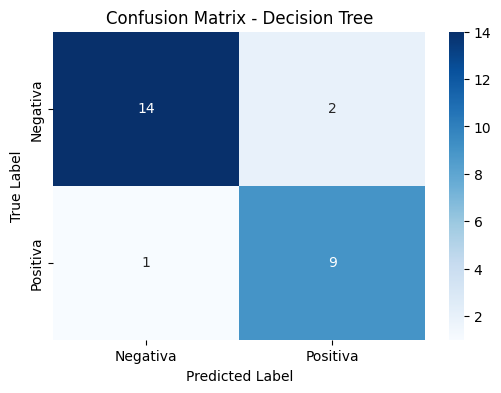

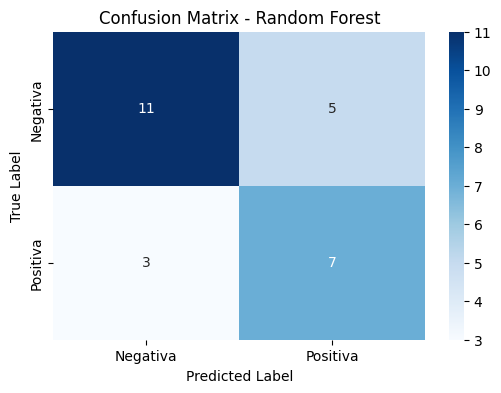

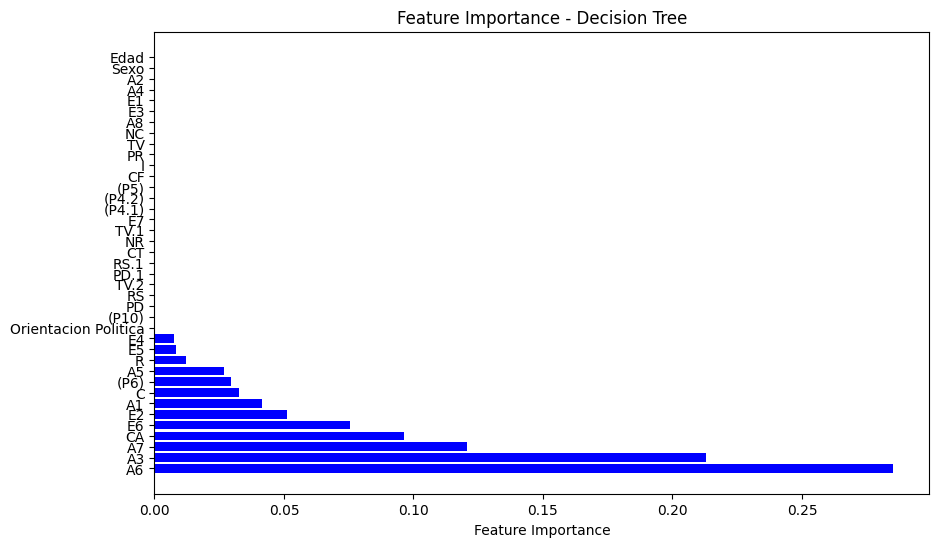

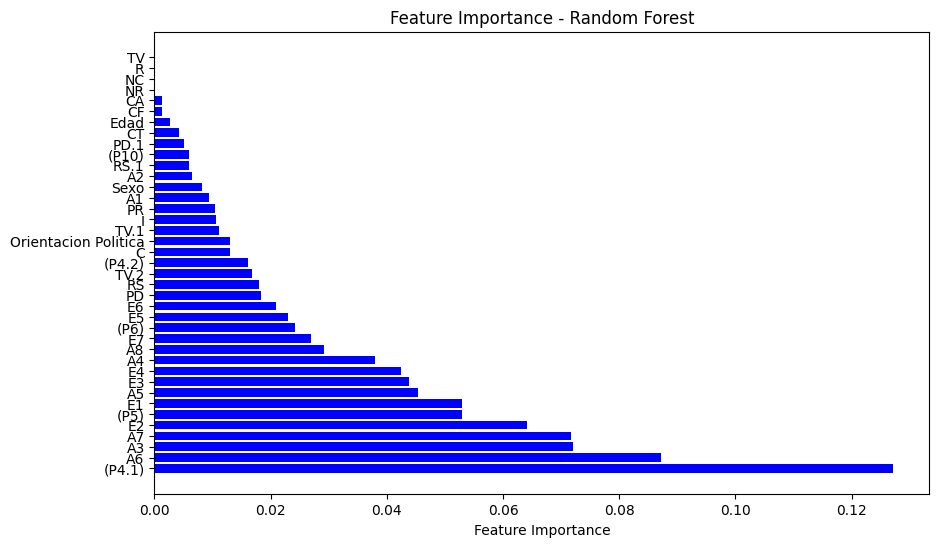

Classification Report - Decision Tree:
              precision    recall  f1-score   support

    Negativa       0.93      0.88      0.90        16
    Positiva       0.82      0.90      0.86        10

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.89        26

Classification Report - Random Forest:
              precision    recall  f1-score   support

    Negativa       0.79      0.69      0.73        16
    Positiva       0.58      0.70      0.64        10

    accuracy                           0.69        26
   macro avg       0.68      0.69      0.68        26
weighted avg       0.71      0.69      0.70        26

Accuracy - Decision Tree: 0.8846, AUC-ROC: 0.8844
Accuracy - Random Forest: 0.6923, AUC-ROC: 0.7875

SVM Results with Decision Tree Top Features:
Accuracy: 0.8846
              precision    recall  f1-score   support

    Negativa       1.00      0.81      0.90       

In [4]:
# Prepare the data
X = data_cleaned.drop('(P1)', axis=1)
y = data_cleaned['(P1)']

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# --- Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
tree_best = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, random_state=42)
tree_best.fit(X_train_scaled, y_train_encoded)
y_pred_tree = tree_best.predict(X_test_scaled)

# --- Random Forest ---
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    criterion='gini', max_depth=30, min_samples_leaf=4,
    min_samples_split=10, n_estimators=30, random_state=42
)
rf.fit(X_train_scaled, y_train_encoded)
y_pred_rf = rf.predict(X_test_scaled)

# --- Evaluate Decision Tree ---
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    classification_report, balanced_accuracy_score,
    f1_score, cohen_kappa_score
)

accuracy_tree = accuracy_score(y_test_encoded, y_pred_tree)
conf_matrix_tree = confusion_matrix(y_test_encoded, y_pred_tree)

if len(np.unique(y_test_encoded)) > 2:
    roc_auc_tree = roc_auc_score(y_test_encoded, tree_best.predict_proba(X_test_scaled), multi_class='ovr')
else:
    roc_auc_tree = roc_auc_score(y_test_encoded, tree_best.predict_proba(X_test_scaled)[:, 1])

# --- Evaluate Random Forest ---
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test_encoded, y_pred_rf)

if len(np.unique(y_test_encoded)) > 2:
    roc_auc_rf = roc_auc_score(y_test_encoded, rf.predict_proba(X_test_scaled), multi_class='ovr')
else:
    roc_auc_rf = roc_auc_score(y_test_encoded, rf.predict_proba(X_test_scaled)[:, 1])

# --- SVM based on DT top features ---
from sklearn.svm import SVC
X_dt = X[["A6", "A3", "A7", "CA", "C"]]
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y, test_size=0.2, random_state=42)

svm_model_dt = SVC(kernel='linear', random_state=42)
svm_model_dt.fit(X_train_dt, le.transform(y_train_dt))
y_pred_svm_dt = svm_model_dt.predict(X_test_dt)
accuracy_svm_dt = accuracy_score(le.transform(y_test_dt), y_pred_svm_dt)

# --- SVM based on RF top features ---
X_rf_svm = X[["A6", "(P5)", "A4", "A8"]]
X_train_rf_svm, X_test_rf_svm, y_train_rf, y_test_rf = train_test_split(X_rf_svm, y, test_size=0.2, random_state=42)

svm_model_rf = SVC(kernel='linear', random_state=42)
svm_model_rf.fit(X_train_rf_svm, le.transform(y_train_rf))
y_pred_svm_rf = svm_model_rf.predict(X_test_rf_svm)
accuracy_svm_rf = accuracy_score(le.transform(y_test_rf), y_pred_svm_rf)

# --- Visualization Functions ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_feature_importance(importances, feature_names, title):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color="b", align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.show()

# --- Plot Results ---
plot_confusion_matrix(conf_matrix_tree, "Confusion Matrix - Decision Tree", le.classes_)
plot_confusion_matrix(conf_matrix_rf, "Confusion Matrix - Random Forest", le.classes_)

plot_feature_importance(tree_best.feature_importances_, X_train.columns, "Feature Importance - Decision Tree")
plot_feature_importance(rf.feature_importances_, X_train.columns, "Feature Importance - Random Forest")

print("Classification Report - Decision Tree:")
print(classification_report(y_test_encoded, y_pred_tree, target_names=le.classes_))

print("Classification Report - Random Forest:")
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

print(f"Accuracy - Decision Tree: {accuracy_tree:.4f}, AUC-ROC: {roc_auc_tree:.4f}")
print(f"Accuracy - Random Forest: {accuracy_rf:.4f}, AUC-ROC: {roc_auc_rf:.4f}")

# --- SVM Summary ---
print("\nSVM Results with Decision Tree Top Features:")
print(f"Accuracy: {accuracy_svm_dt:.4f}")
print(classification_report(le.transform(y_test_dt), y_pred_svm_dt, target_names=le.classes_))

print("\nSVM Results with Random Forest Top Features:")
print(f"Accuracy: {accuracy_svm_rf:.4f}")
print(classification_report(le.transform(y_test_rf), y_pred_svm_rf, target_names=le.classes_))

# --- Additional Balanced Metrics ---
print("\n--- Balanced Metrics ---")

# Decision Tree
balanced_acc_tree = balanced_accuracy_score(y_test_encoded, y_pred_tree)
macro_f1_tree = f1_score(y_test_encoded, y_pred_tree, average='macro')
kappa_tree = cohen_kappa_score(y_test_encoded, y_pred_tree)
print(f"Decision Tree: Balanced Acc = {balanced_acc_tree:.4f}, Macro F1 = {macro_f1_tree:.4f}, Kappa = {kappa_tree:.4f}")

# Random Forest
balanced_acc_rf = balanced_accuracy_score(y_test_encoded, y_pred_rf)
macro_f1_rf = f1_score(y_test_encoded, y_pred_rf, average='macro')
kappa_rf = cohen_kappa_score(y_test_encoded, y_pred_rf)
print(f"Random Forest: Balanced Acc = {balanced_acc_rf:.4f}, Macro F1 = {macro_f1_rf:.4f}, Kappa = {kappa_rf:.4f}")

# SVM DT Features
balanced_acc_svm_dt = balanced_accuracy_score(le.transform(y_test_dt), y_pred_svm_dt)
macro_f1_svm_dt = f1_score(le.transform(y_test_dt), y_pred_svm_dt, average='macro')
kappa_svm_dt = cohen_kappa_score(le.transform(y_test_dt), y_pred_svm_dt)
print(f"SVM (DT Features): Balanced Acc = {balanced_acc_svm_dt:.4f}, Macro F1 = {macro_f1_svm_dt:.4f}, Kappa = {kappa_svm_dt:.4f}")

# SVM RF Features
balanced_acc_svm_rf = balanced_accuracy_score(le.transform(y_test_rf), y_pred_svm_rf)
macro_f1_svm_rf = f1_score(le.transform(y_test_rf), y_pred_svm_rf, average='macro')
kappa_svm_rf = cohen_kappa_score(le.transform(y_test_rf), y_pred_svm_rf)
print(f"SVM (RF Features): Balanced Acc = {balanced_acc_svm_rf:.4f}, Macro F1 = {macro_f1_svm_rf:.4f}, Kappa = {kappa_svm_rf:.4f}")


In [5]:
# === Prepare data ===
X = data_cleaned.drop('(P1)', axis=1)
y = data_cleaned['(P1)']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === Selected top features ===
features_dt = ["A6", "A3", "A7", "CA", "C"]         # From Decision Tree
features_rf = ["A6", "(P5)", "A4", "A8"]            # From Random Forest

# === Cross-validation evaluation function ===
def evaluate_model_cv(model, X, y_encoded, model_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs, bal_accs, f1s, kappas, aucs = [], [], [], [], []

    for train_idx, test_idx in skf.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Probability estimates for AUC
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_scaled)
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(X_test_scaled)
            y_proba = np.vstack([1 - scores, scores]).T if scores.ndim == 1 else scores
        else:
            y_proba = None

        accs.append(accuracy_score(y_test, y_pred))
        bal_accs.append(balanced_accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, average='macro'))
        kappas.append(cohen_kappa_score(y_test, y_pred))

        # AUC-ROC computation
        if y_proba is not None:
            if len(np.unique(y_encoded)) > 2:
                aucs.append(roc_auc_score(y_test, y_proba, multi_class='ovr'))
            else:
                aucs.append(roc_auc_score(y_test, y_proba[:, 1]))

    # Print average performance with standard deviations
    print(f"\n--- {model_name} ---")
    print(f"Accuracy:           {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"Balanced Accuracy:  {np.mean(bal_accs):.4f} ± {np.std(bal_accs):.4f}")
    print(f"Macro F1-score:     {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    print(f"Cohen's Kappa:      {np.mean(kappas):.4f} ± {np.std(kappas):.4f}")
    print(f"ROC AUC:            {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# === Models to evaluate ===

# 1. Decision Tree using all features
evaluate_model_cv(
    DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, random_state=42),
    X, y_encoded, "Decision Tree (All Features)"
)

# 2. Random Forest using all features
evaluate_model_cv(
    RandomForestClassifier(criterion='gini', max_depth=30, min_samples_leaf=4,
                           min_samples_split=10, n_estimators=30, random_state=42),
    X, y_encoded, "Random Forest (All Features)"
)

# 3. SVM using top features from Decision Tree
evaluate_model_cv(
    SVC(kernel='linear', probability=True, random_state=42),
    X[features_dt], y_encoded, "SVM (Top Features from Decision Tree)"
)

# 4. SVM using top features from Random Forest
evaluate_model_cv(
    SVC(kernel='linear', probability=True, random_state=42),
    X[features_rf], y_encoded, "SVM (Top Features from Random Forest)"
)



--- Decision Tree (All Features) ---
Accuracy:           0.6231 ± 0.0510
Balanced Accuracy:  0.6250 ± 0.0509
Macro F1-score:     0.6129 ± 0.0678
Cohen's Kappa:      0.2488 ± 0.1018
ROC AUC:            0.7049 ± 0.0425

--- Random Forest (All Features) ---
Accuracy:           0.7154 ± 0.0713
Balanced Accuracy:  0.7179 ± 0.0693
Macro F1-score:     0.7140 ± 0.0719
Cohen's Kappa:      0.4340 ± 0.1400
ROC AUC:            0.7902 ± 0.0554

--- SVM (Top Features from Decision Tree) ---
Accuracy:           0.7385 ± 0.1341
Balanced Accuracy:  0.7383 ± 0.1340
Macro F1-score:     0.7362 ± 0.1349
Cohen's Kappa:      0.4766 ± 0.2679
ROC AUC:            0.8295 ± 0.0970

--- SVM (Top Features from Random Forest) ---
Accuracy:           0.6462 ± 0.0662
Balanced Accuracy:  0.6474 ± 0.0649
Macro F1-score:     0.6452 ± 0.0660
Cohen's Kappa:      0.2943 ± 0.1303
ROC AUC:            0.7345 ± 0.0576


In [ ]:
# === Feature Importance for the Decision Tree Model ===
# Assuming 'tree_best' is a previously trained DecisionTreeClassifier
importances_tree = tree_best.feature_importances_

# Sort features by importance (descending order)
indices_tree = np.argsort(importances_tree)[::-1]
feature_names_tree = X_train.columns

# Print the top 15 most important features
print("Top 15 Most Important Features (Decision Tree):")
for i in indices_tree[:15]:
    print(f"{feature_names_tree[i]}: {importances_tree[i]:.4f}")

# === Feature Importance for the Random Forest Model ===
# Assuming 'rf' is a previously trained RandomForestClassifier
importances_rf = rf.feature_importances_

# Sort features by importance (descending order)
indices_rf = np.argsort(importances_rf)[::-1]
feature_names_rf = X_train.columns

# Print the top 15 most important features
print("\nTop 15 Most Important Features (Random Forest):")
for i in indices_rf[:15]:
    print(f"{feature_names_rf[i]}: {importances_rf[i]:.4f}")


Importancia de las 15 Características Más Altas (Árbol de Decisión):
A6: 0.2850
A3: 0.2130
A7: 0.1205
CA: 0.0965
E6: 0.0754
E2: 0.0513
A1: 0.0413
C: 0.0328
(P6): 0.0295
A5: 0.0267
R: 0.0121
E5: 0.0084
E4: 0.0075
Orientacion Politica: 0.0000
(P10): 0.0000

Importancia de las 15 Características Más Altas (Random Forest):
(P4.1): 0.1271
A6: 0.0873
A3: 0.0721
A7: 0.0717
E2: 0.0641
(P5): 0.0530
E1: 0.0529
A5: 0.0453
E3: 0.0438
E4: 0.0425
A4: 0.0379
A8: 0.0292
E7: 0.0269
(P6): 0.0243
E5: 0.0230


## Post exposure Data

In [2]:
archivo = '/content/post_exposure_data.xlsx'
df = pd.read_excel(archivo)
print(df.head())
data_cleaned = df.dropna()
df = df.drop(columns=['Condition'])
data_cleaned['(P1)'] = data_cleaned['(P1)'].apply(lambda x: 'Positiva' if x >= 5 else 'Negativa')
print(data_cleaned['(P1)'].head())

   Em1  Em2  Em3  Em4  Em5  Em6  Em7  Em8  Em9  Em10  ...  C  LD  S  S.1  MS  \
0    1    1    1    1    1    1    1    1    1   1.0  ...  7   1  3    7   5   
1    5    5    4    1    1    1    1    2    4   3.0  ...  2   2  3    4   6   
2    7    4    5    1    1    1    1    1    1   1.0  ...  5   1  3    3   4   
3    2    2    2    2    2    2    2    2    2   2.0  ...  1   1  1    1   1   
4    4    3    5    4    1    1    1    1    1   1.0  ...  2   2  2    2   2   

   D  I  A  (P1)  Condition  
0  7  7  5     5   Positivo  
1  6  6  5     6   Positivo  
2  6  2  6     4   Positivo  
3  1  1  1     5   Positivo  
4  2  2  2     4   Positivo  

[5 rows x 21 columns]
0    Positiva
1    Positiva
2    Negativa
3    Positiva
4    Negativa
Name: (P1), dtype: object


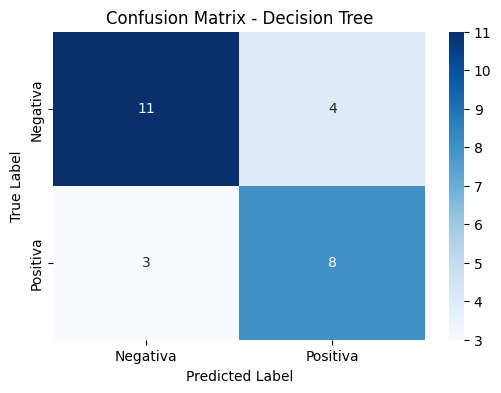

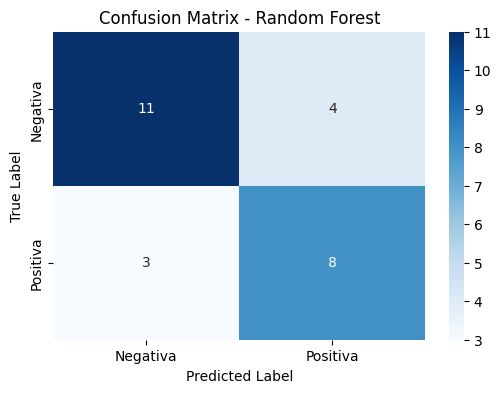

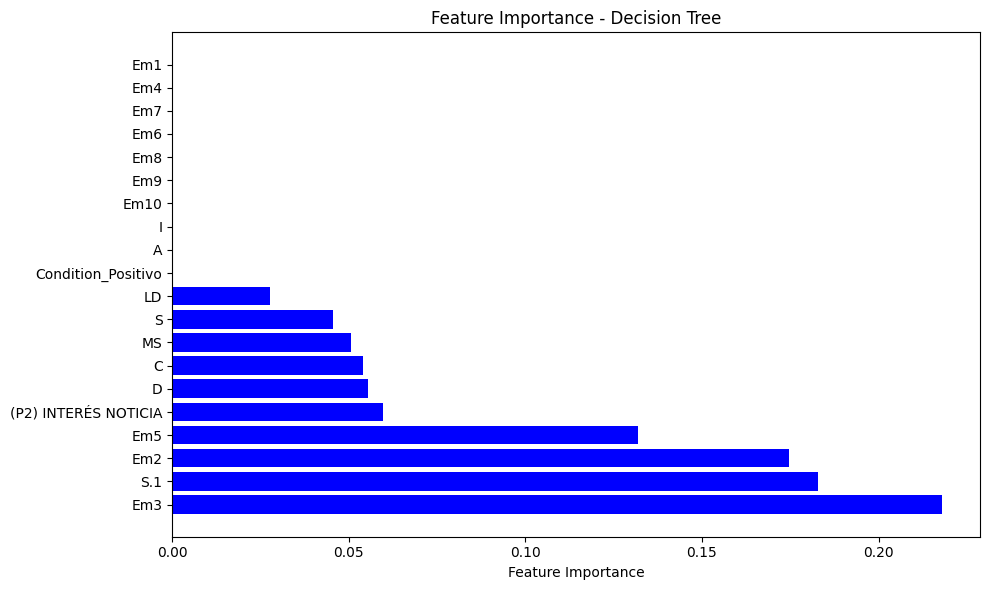

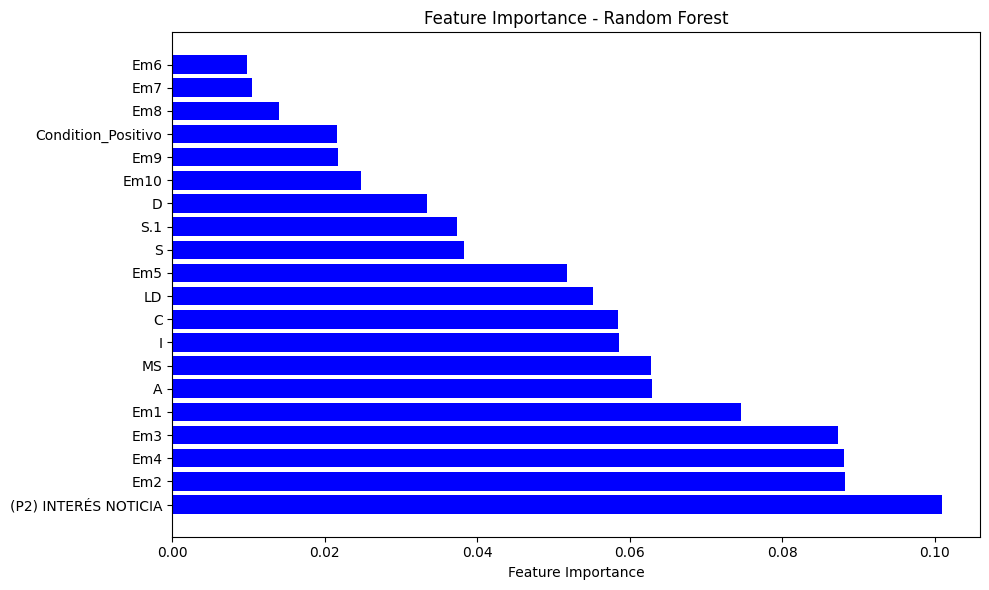

Classification Report - Decision Tree:
              precision    recall  f1-score   support

    Negativa       0.79      0.73      0.76        15
    Positiva       0.67      0.73      0.70        11

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.74      0.73      0.73        26

Classification Report - Random Forest:
              precision    recall  f1-score   support

    Negativa       0.79      0.73      0.76        15
    Positiva       0.67      0.73      0.70        11

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.74      0.73      0.73        26

Accuracy - Decision Tree: 0.7308, AUC-ROC: 0.6152
Accuracy - Random Forest: 0.7308, AUC-ROC: 0.7455

SVM Results with Decision Tree Top Features:
Accuracy: 0.8077
              precision    recall  f1-score   support

    Negativa       0.86      0.80      0.83       

In [3]:
# --- Prepare Data ---
# Encode categorical input variables
X = pd.get_dummies(data_cleaned.drop('(P1)', axis=1), drop_first=True)
y = data_cleaned['(P1)']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# --- Decision Tree ---
tree_best = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, random_state=42)
tree_best.fit(X_train_scaled, y_train_encoded)
y_test_pred_tree = tree_best.predict(X_test_scaled)

# --- Random Forest ---
rf = RandomForestClassifier(criterion='gini', max_depth=30, min_samples_leaf=4, min_samples_split=10,
                            n_estimators=30, random_state=42)
rf.fit(X_train_scaled, y_train_encoded)
y_test_pred_rf = rf.predict(X_test_scaled)

# --- Evaluation (Tree and RF) ---
roc_auc_tree = roc_auc_score(y_test_encoded, tree_best.predict_proba(X_test_scaled)[:, 1])
roc_auc_rf = roc_auc_score(y_test_encoded, rf.predict_proba(X_test_scaled)[:, 1])

# --- SVM: Use same selected features ---
X_dt = data_cleaned[['Em3', '(P2) INTERÉS NOTICIA', 'A', 'C']]
X_rf_features = data_cleaned[['Em3', 'Em2', 'D', 'C', 'LD', 'S.1', 'S']]

# One-hot encode if needed
X_dt_encoded = pd.get_dummies(X_dt, drop_first=True)
X_rf_encoded = pd.get_dummies(X_rf_features, drop_first=True)

# Train-test split for SVM
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt_encoded, y, test_size=0.2, random_state=42)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf_encoded, y, test_size=0.2, random_state=42)

# Train SVM (DT features)
svm_model_dt = SVC(kernel='linear', probability=True, random_state=42)
svm_model_dt.fit(X_train_dt, le.transform(y_train_dt))
y_pred_svm_dt = svm_model_dt.predict(X_test_dt)

# Train SVM (RF features)
svm_model_rf = SVC(kernel='linear', probability=True, random_state=42)
svm_model_rf.fit(X_train_rf, le.transform(y_train_rf))
y_pred_svm_rf = svm_model_rf.predict(X_test_rf)

# --- Visualization ---
def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_feature_importance(importances, feature_names, title):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color="b", align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

# --- Confusion Matrices ---
plot_confusion_matrix(confusion_matrix(y_test_encoded, y_test_pred_tree), "Confusion Matrix - Decision Tree", le.classes_)
plot_confusion_matrix(confusion_matrix(y_test_encoded, y_test_pred_rf), "Confusion Matrix - Random Forest", le.classes_)

# --- Feature Importance ---
plot_feature_importance(tree_best.feature_importances_, X_train.columns, "Feature Importance - Decision Tree")
plot_feature_importance(rf.feature_importances_, X_train.columns, "Feature Importance - Random Forest")

# --- Reports ---
print("Classification Report - Decision Tree:")
print(classification_report(y_test_encoded, y_test_pred_tree, target_names=le.classes_))

print("Classification Report - Random Forest:")
print(classification_report(y_test_encoded, y_test_pred_rf, target_names=le.classes_))

print(f"Accuracy - Decision Tree: {accuracy_score(y_test_encoded, y_test_pred_tree):.4f}, AUC-ROC: {roc_auc_tree:.4f}")
print(f"Accuracy - Random Forest: {accuracy_score(y_test_encoded, y_test_pred_rf):.4f}, AUC-ROC: {roc_auc_rf:.4f}")

# --- SVM Reports ---
print("\nSVM Results with Decision Tree Top Features:")
print(f"Accuracy: {accuracy_score(le.transform(y_test_dt), y_pred_svm_dt):.4f}")
print(classification_report(le.transform(y_test_dt), y_pred_svm_dt, target_names=le.classes_))

print("\nSVM Results with Random Forest Top Features:")
print(f"Accuracy: {accuracy_score(le.transform(y_test_rf), y_pred_svm_rf):.4f}")
print(classification_report(le.transform(y_test_rf), y_pred_svm_rf, target_names=le.classes_))

# --- Additional Metrics: Balanced Accuracy, Macro F1, Cohen's Kappa ---
print("\n--- Balanced Performance Metrics ---")
print(f"Decision Tree: Balanced Accuracy = {balanced_accuracy_score(y_test_encoded, y_test_pred_tree):.4f}, "
      f"Macro F1 = {f1_score(y_test_encoded, y_test_pred_tree, average='macro'):.4f}, "
      f"Kappa = {cohen_kappa_score(y_test_encoded, y_test_pred_tree):.4f}")

print(f"Random Forest: Balanced Accuracy = {balanced_accuracy_score(y_test_encoded, y_test_pred_rf):.4f}, "
      f"Macro F1 = {f1_score(y_test_encoded, y_test_pred_rf, average='macro'):.4f}, "
      f"Kappa = {cohen_kappa_score(y_test_encoded, y_test_pred_rf):.4f}")

print(f"SVM (DT Features): Balanced Accuracy = {balanced_accuracy_score(le.transform(y_test_dt), y_pred_svm_dt):.4f}, "
      f"Macro F1 = {f1_score(le.transform(y_test_dt), y_pred_svm_dt, average='macro'):.4f}, "
      f"Kappa = {cohen_kappa_score(le.transform(y_test_dt), y_pred_svm_dt):.4f}")

print(f"SVM (RF Features): Balanced Accuracy = {balanced_accuracy_score(le.transform(y_test_rf), y_pred_svm_rf):.4f}, "
      f"Macro F1 = {f1_score(le.transform(y_test_rf), y_pred_svm_rf, average='macro'):.4f}, "
      f"Kappa = {cohen_kappa_score(le.transform(y_test_rf), y_pred_svm_rf):.4f}")


In [4]:
# === LOAD AND PREPROCESS DATA ===
file_path = '/content/post_exposure_data.xlsx'
df = pd.read_excel(file_path)

# Drop unused column and missing values
df = df.drop(columns=['Condition'])
df = df.dropna()

# Binarize target variable (P1)
df['(P1)'] = df['(P1)'].apply(lambda x: 'Positive' if x >= 5 else 'Negative')

# Encode target variable
y = df['(P1)']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode all features except target
X_full = pd.get_dummies(df.drop('(P1)', axis=1), drop_first=True)

# Select top features (based on your original selection)
X_dt = pd.get_dummies(df[['Em3', '(P2) INTERÉS NOTICIA', 'A', 'C']], drop_first=True)
X_rf = pd.get_dummies(df[['Em3', 'Em2', 'D', 'C', 'LD', 'S.1', 'S']], drop_first=True)

# === CROSS-VALIDATION EVALUATION FUNCTION ===
def evaluate_model_cv(model, X, y_encoded, model_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs, bal_accs, f1s, kappas, aucs = [], [], [], [], []

    for train_idx, test_idx in skf.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Get prediction probabilities for AUC
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_scaled)
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(X_test_scaled)
            y_proba = np.vstack([1 - scores, scores]).T if scores.ndim == 1 else scores
        else:
            y_proba = None

        accs.append(accuracy_score(y_test, y_pred))
        bal_accs.append(balanced_accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, average='macro'))
        kappas.append(cohen_kappa_score(y_test, y_pred))

        if y_proba is not None:
            if len(np.unique(y_encoded)) > 2:
                aucs.append(roc_auc_score(y_test, y_proba, multi_class='ovr'))
            else:
                aucs.append(roc_auc_score(y_test, y_proba[:, 1]))

    # Print results
    print(f"\n--- {model_name} ---")
    print(f"Accuracy:           {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"Balanced Accuracy:  {np.mean(bal_accs):.4f} ± {np.std(bal_accs):.4f}")
    print(f"Macro F1-score:     {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    print(f"Cohen's Kappa:      {np.mean(kappas):.4f} ± {np.std(kappas):.4f}")
    print(f"ROC AUC:            {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# === MODEL EVALUATION ===

# 1. Decision Tree with all features
evaluate_model_cv(
    DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, random_state=42),
    X_full, y_encoded, "Decision Tree (All Features)"
)

# 2. Random Forest with all features
evaluate_model_cv(
    RandomForestClassifier(criterion='gini', max_depth=30, min_samples_leaf=4,
                           min_samples_split=10, n_estimators=30, random_state=42),
    X_full, y_encoded, "Random Forest (All Features)"
)

# 3. SVM using top features from Decision Tree
evaluate_model_cv(
    SVC(kernel='linear', probability=True, random_state=42),
    X_dt, y_encoded, "SVM (Top Features from Decision Tree)"
)

# 4. SVM using top features from Random Forest
evaluate_model_cv(
    SVC(kernel='linear', probability=True, random_state=42),
    X_rf, y_encoded, "SVM (Top Features from Random Forest)"
)




--- Decision Tree (All Features) ---
Accuracy:           0.6126 ± 0.0399
Balanced Accuracy:  0.6141 ± 0.0410
Macro F1-score:     0.6092 ± 0.0396
Cohen's Kappa:      0.2273 ± 0.0813
ROC AUC:            0.6863 ± 0.0477

--- Random Forest (All Features) ---
Accuracy:           0.6831 ± 0.0869
Balanced Accuracy:  0.6833 ± 0.0873
Macro F1-score:     0.6820 ± 0.0874
Cohen's Kappa:      0.3663 ± 0.1741
ROC AUC:            0.7340 ± 0.0625

--- SVM (Top Features from Decision Tree) ---
Accuracy:           0.6742 ± 0.0478
Balanced Accuracy:  0.6737 ± 0.0482
Macro F1-score:     0.6670 ± 0.0494
Cohen's Kappa:      0.3476 ± 0.0962
ROC AUC:            0.7016 ± 0.0489

--- SVM (Top Features from Random Forest) ---
Accuracy:           0.6889 ± 0.0821
Balanced Accuracy:  0.6891 ± 0.0818
Macro F1-score:     0.6867 ± 0.0814
Cohen's Kappa:      0.3781 ± 0.1638
ROC AUC:            0.7655 ± 0.0861


In [5]:
import numpy as np

# === Feature importance for the Decision Tree model ===
# Assuming 'tree_best' is already trained
importances_tree = tree_best.feature_importances_

# Sort features by importance (descending)
indices_tree = np.argsort(importances_tree)[::-1]
feature_names_tree = X_train.columns

# Print the top 15 most important features for Decision Tree
print("Top 15 Most Important Features (Decision Tree):")
for i in indices_tree[:15]:
    print(f"{feature_names_tree[i]}: {importances_tree[i]:.4f}")

# === Feature importance for the Random Forest model ===
# Assuming 'rf' is already trained
importances_rf = rf.feature_importances_

# Sort features by importance (descending)
indices_rf = np.argsort(importances_rf)[::-1]
feature_names_rf = X_train.columns

# Print the top 15 most important features for Random Forest
print("\nTop 15 Most Important Features (Random Forest):")
for i in indices_rf[:15]:
    print(f"{feature_names_rf[i]}: {importances_rf[i]:.4f}")


Top 15 Most Important Features (Decision Tree):
Em3: 0.2178
S.1: 0.1830
Em2: 0.1746
Em5: 0.1318
(P2) INTERÉS NOTICIA: 0.0597
D: 0.0553
C: 0.0541
MS: 0.0507
S: 0.0454
LD: 0.0276
Condition_Positivo: 0.0000
A: 0.0000
I: 0.0000
Em10: 0.0000
Em9: 0.0000

Top 15 Most Important Features (Random Forest):
(P2) INTERÉS NOTICIA: 0.1009
Em2: 0.0882
Em4: 0.0881
Em3: 0.0873
Em1: 0.0746
A: 0.0629
MS: 0.0628
I: 0.0586
C: 0.0584
LD: 0.0552
Em5: 0.0517
S: 0.0382
S.1: 0.0373
D: 0.0333
Em10: 0.0247


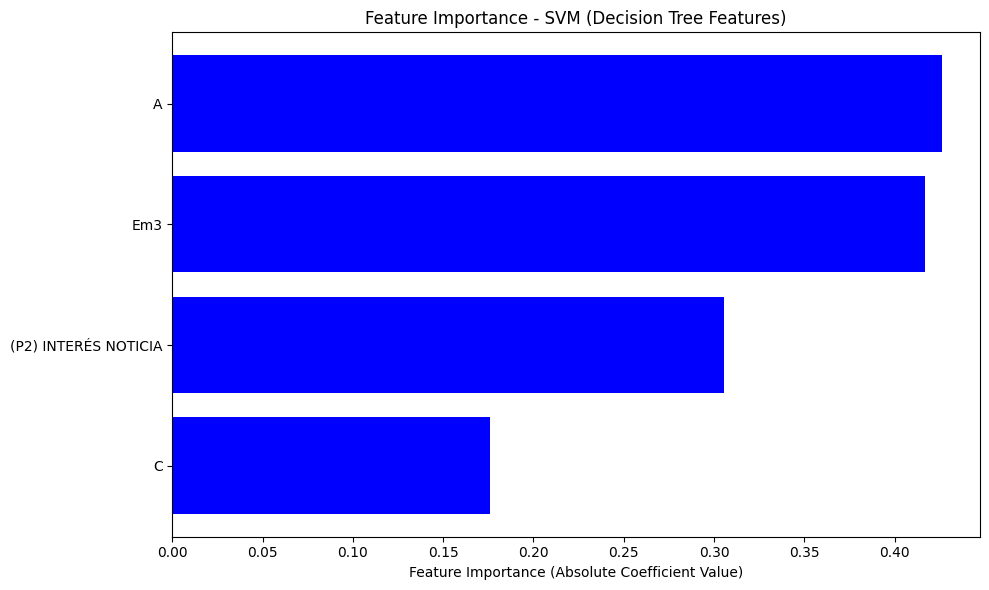

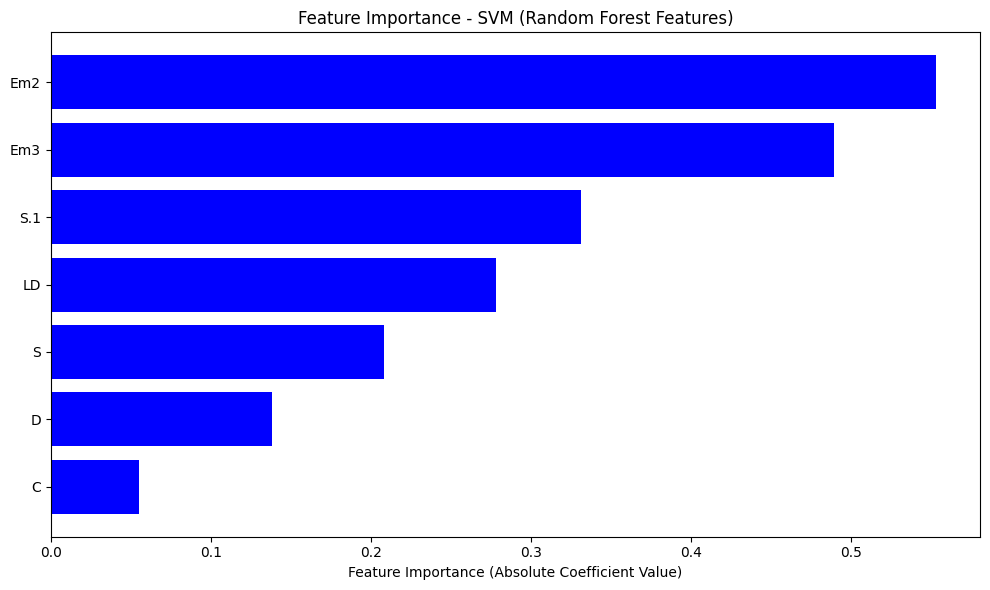

In [6]:
# === Feature importance for SVM based on Decision Tree features ===
coef_dt = svm_model_dt.coef_[0]
importance_dt = np.abs(coef_dt)

# === Feature importance for SVM based on Random Forest features ===
coef_rf = svm_model_rf.coef_[0]
importance_rf = np.abs(coef_rf)

# === Visualization function ===
def plot_svm_feature_importance(importance, feature_names, title):
    indices = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importance[indices], color="b", align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance (Absolute Coefficient Value)')
    plt.gca().invert_yaxis()  # Show most important at the top
    plt.tight_layout()
    plt.show()

# Feature names for SVM with Decision Tree-selected features
feature_names_dt = X_dt.columns

# Feature names for SVM with Random Forest-selected features
feature_names_rf = X_rf_encoded.columns

# === Plot feature importances ===
plot_svm_feature_importance(importance_dt, feature_names_dt, "Feature Importance - SVM (Decision Tree Features)")
plot_svm_feature_importance(importance_rf, feature_names_rf, "Feature Importance - SVM (Random Forest Features)")


In [7]:
# === Numerical coefficients for SVM based on Decision Tree features ===
coef_dt = svm_model_dt.coef_[0]
importance_dt = np.abs(coef_dt)

# === Numerical coefficients for SVM based on Random Forest features ===
coef_rf = svm_model_rf.coef_[0]
importance_rf = np.abs(coef_rf)

# Print coefficients for SVM with Decision Tree features
print("Coefficients - SVM (Decision Tree Features):")
for feature, coef in zip(X_dt.columns, coef_dt):
    print(f"{feature}: {coef:.4f}")

# Print coefficients for SVM with Random Forest features
# Ensure you're referencing the correct variable (X_rf_encoded)
print("\nCoefficients - SVM (Random Forest Features):")
for feature, coef in zip(X_rf_encoded.columns, coef_rf):
    print(f"{feature}: {coef:.4f}")


Coefficients - SVM (Decision Tree Features):
Em3: -0.4168
(P2) INTERÉS NOTICIA: 0.3056
A: -0.4260
C: 0.1760

Coefficients - SVM (Random Forest Features):
Em3: -0.4896
Em2: 0.5531
D: -0.1383
C: 0.0553
LD: -0.2781
S.1: 0.3316
S: -0.2082
